# Project 1: 图像特征提取与匹配

启动Jupyter并打开`Project1.ipynb`。

在本项目中，您将构建一个图像特征匹配器，从简单的卷积运算开始，然后进行兴趣点检测和描述符提取。一旦你有一个基本的功能匹配器工作，尝试一些改进并记录你的结果。

In [34]:
import numpy as np
import os.path
from time import time
import types
import matplotlib.pyplot as plt

import im_util
import interest_point

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# force auto-reload of import modules before running code 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 卷积和图像滤波 [5分]

首先编写代码来执行一维卷积。打开 `im_util.py` 并编辑函数 `convolve_1d`。你应该只使用基本的 numpy 数组操作和循环。现在不用担心效率问题。与参考的 numpy 版本相比，你应该会看到很小的误差。

注意，卷积和相关（correlation）在对核（kernel）进行简单操作后是相同的（它是什么操作？）。对于哪些核，卷积和相关的结果是相同的？

In [35]:
"""
Test of convolve_1d
"""
print('[ Test convolve_1d ]')
x = (np.random.rand(20)>0.8).astype(np.float32)
k = np.array([1,3,1])
y1 = im_util.convolve_1d(x, k)
y2 = np.convolve(x, k, 'same')
y3 = np.correlate(x, k, 'same')
print(' convolve error = ', np.sum((y1-y2)**2))
print(' correlate error = ', np.sum((y1-y3)**2))

[ Test convolve_1d ]
 convolve error =  0.0
 correlate error =  0.0


我们现在将使用一维核对二维图像进行卷积。通过对图像的每一行进行卷积，完成 `im_util.py` 中的 `convolve_rows` 函数。运行下面的代码，并检查图像输出是否合理。

In [36]:
"""
Test of convolve_image
"""
image_filename='data/test/100-0038_img.jpg'

print('[ Test convolve_image ]')
im = im_util.image_open(image_filename)
k = np.array([1,2,3,4,5,6,5,4,3,2,1])
print(' convolve_rows')
t0=time()
im1 = im_util.convolve_rows(im, k)
t1=time()
print(' % .2f secs' % (t1-t0))
print(' scipy convolve')
t0=time()
im2 = im_util.convolve(im, np.expand_dims(k,0))
t1=time()
print(' % .2f secs' % (t1-t0))
print(' convolve_image error =', np.sum((im1-im2)**2))

# optionally plot images for debugging
#im1_norm=im_util.normalise_01(im1)
#im2_norm=im_util.normalise_01(im2)
#ax1,ax2=im_util.plot_two_images(im1_norm, im2_norm)          

[ Test convolve_image ]
 convolve_rows
  35.28 secs
 scipy convolve
  0.03 secs
 convolve_image error = 1.3236821116945074e-06


你可能会发现 scipy 的卷积运行速度比你的版本快得多。为了加快速度，你可以在所有后续实验中使用这个版本（`im_util.convolve`）。请注意，这将执行一个通用的二维卷积，并将二维核作为输入。

现在编写代码来执行高斯模糊。首先实现函数 `gauss_kernel` 来计算一维高斯核。然后完成 `convolve_gaussian` 来执行与这个核的可分离卷积。

[ Test convolve_gaussian ]
 gauss kernel = 
[[0.01349774 0.02156933 0.0323794  0.04566227 0.06049268 0.07528436
  0.08801633 0.09666703 0.09973557 0.09666703 0.08801633 0.07528436
  0.06049268 0.04566227 0.0323794  0.02156933 0.01349774]]
  0.03 secs


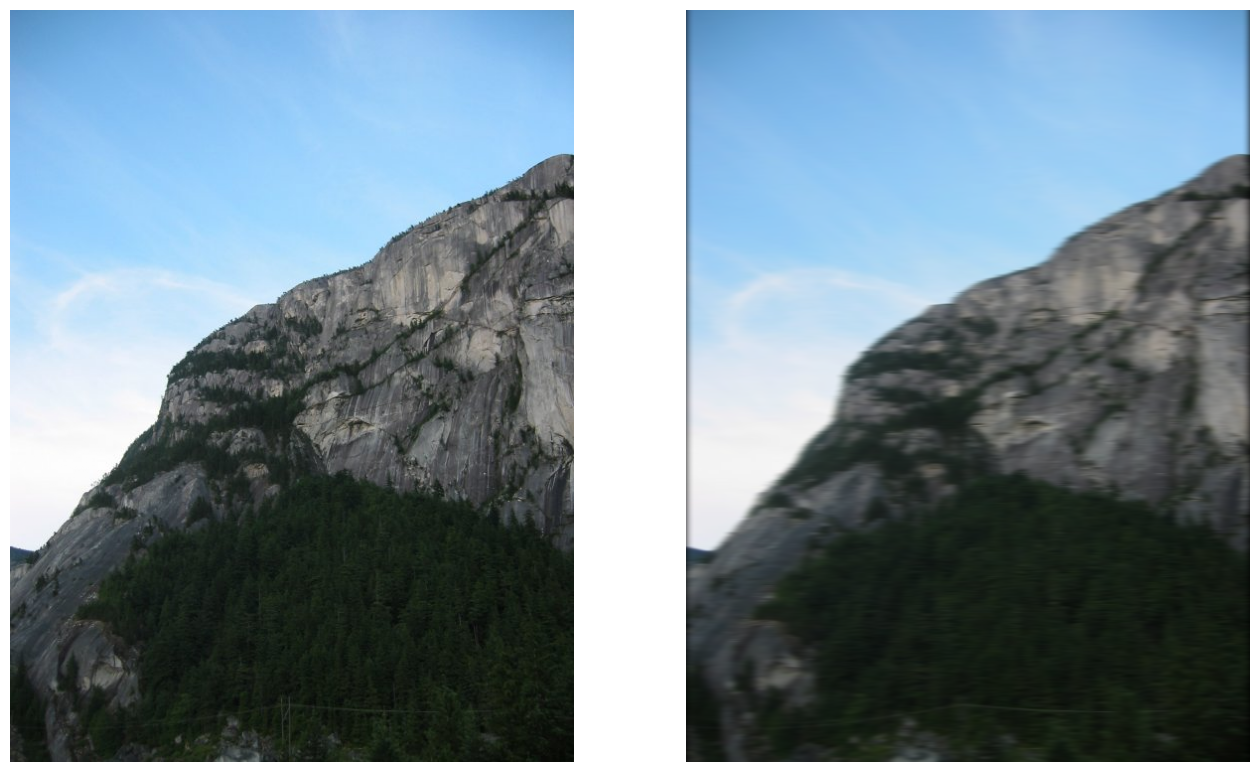

In [37]:
"""
Gaussian blurring test
"""
print('[ Test convolve_gaussian ]')

sigma=4.0
k=im_util.gauss_kernel(sigma)
print(' gauss kernel = ')
print(k)

t0=time()
im1 = im_util.convolve_gaussian(im, sigma)
t1=time()
print(' % .2f secs' % (t1-t0))

ax1,ax2=im_util.plot_two_images(im, im1)

现在在函数 `compute_gradients` 中编写代码来计算水平和垂直梯度。使用在每个方向上卷积的显式核（即，不要使用内置函数，如 `numpy.gradient`）。运行下面的代码，并检查输出是否看起来合理。

[ Test gradient computation ]


(<AxesSubplot:>, <AxesSubplot:>)

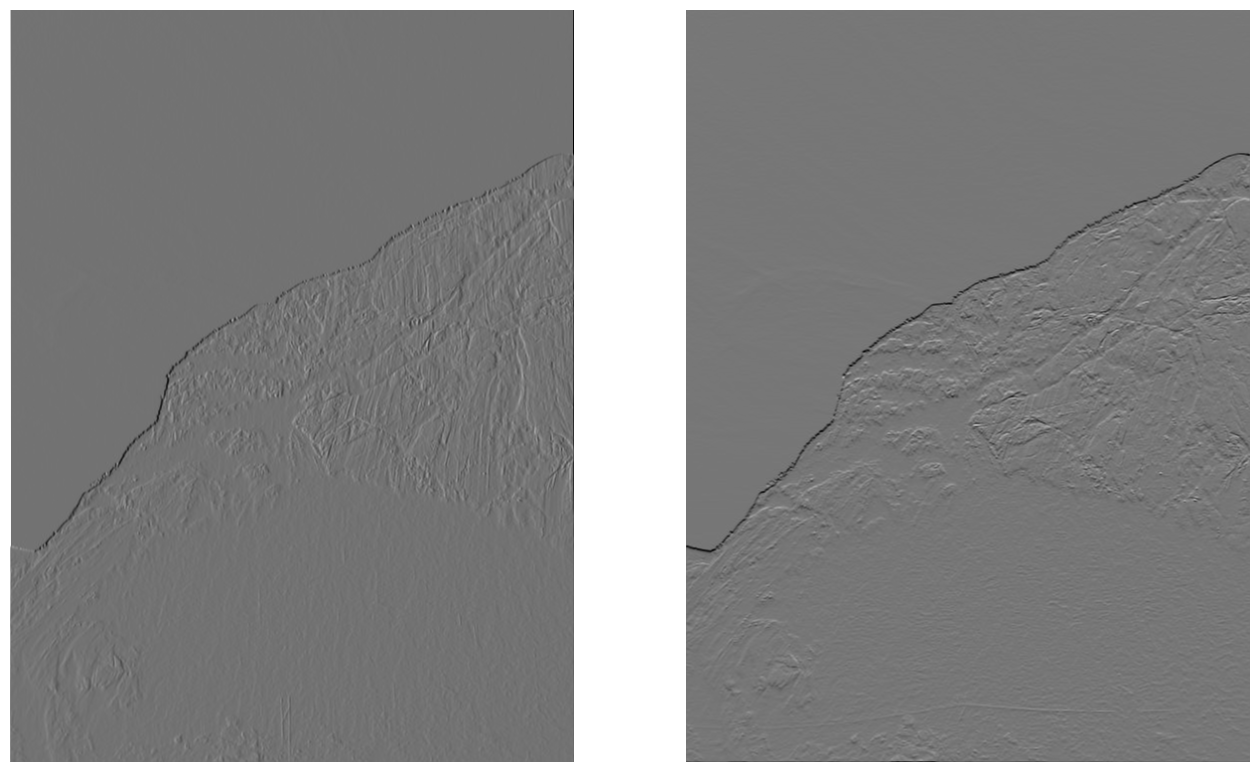

In [38]:
"""
Gradient computation test
"""
print('[ Test gradient computation ]')
img = np.mean(im,2,keepdims=True)
Ix,Iy = im_util.compute_gradients(img)

# copy greyvalue to RGB channels
Ix_out = im_util.grey_to_rgb(im_util.normalise_01(Ix))
Iy_out = im_util.grey_to_rgb(im_util.normalise_01(Iy))

im_util.plot_two_images(Ix_out, Iy_out)

### 兴趣点提取器 [5分]

现在你将使用这些卷积函数来实现一个角点或兴趣点检测器。选择一个知名的检测器，如 Harris 或 DoG，并在 `interest_point.py` 的 `corner_function` 中实现兴趣点强度函数。运行下面的代码来可视化你的角点函数输出。接下来，通过填写同一文件中的 `find_local_maxima`，将这个函数的局部最大值检测为角点。

[ Compute corner strength ]
[ Find local maxima ]


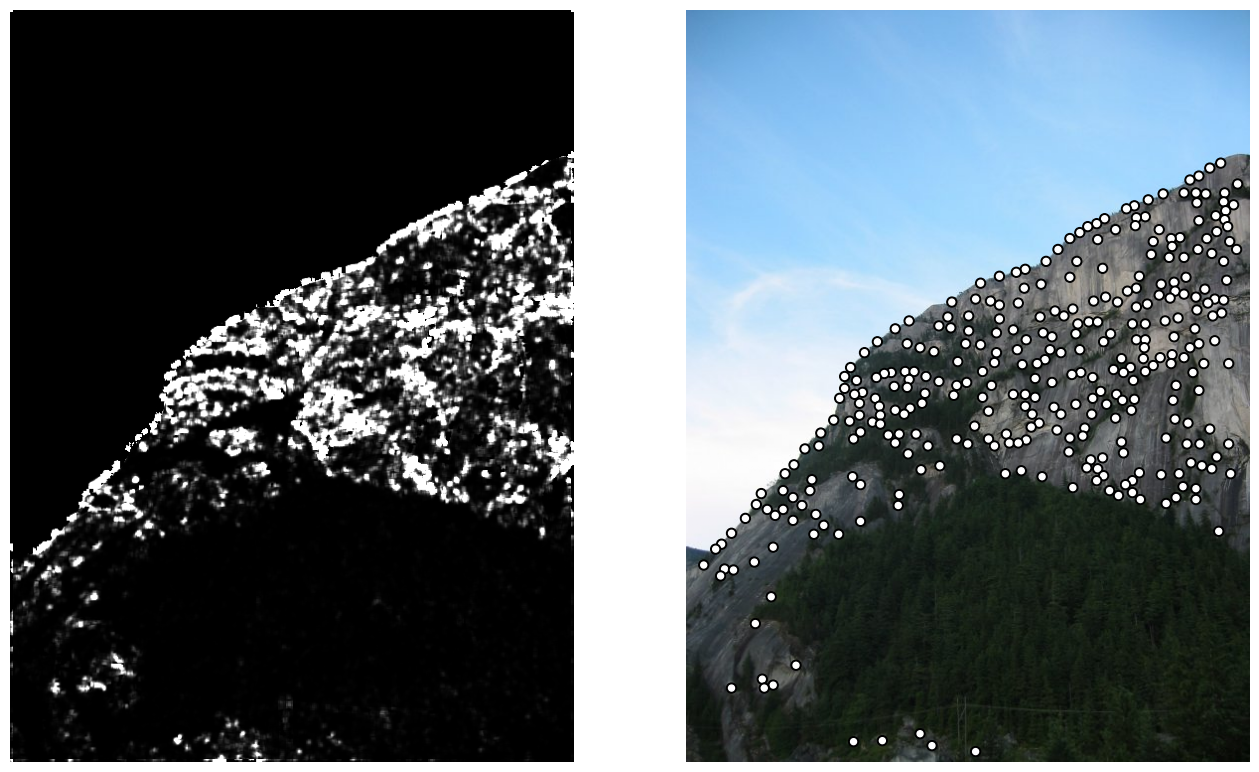

In [39]:
"""
Compute corner strength function
"""
print('[ Compute corner strength ]')
ip_ex = interest_point.InterestPointExtractor()
ip_fun = ip_ex.corner_function(img)

# normalise for display
[mn,mx]=np.percentile(ip_fun,[5,95])
small_val=1e-9
ip_fun_norm=(ip_fun-mn)/(mx-mn+small_val)
ip_fun_norm=np.maximum(np.minimum(ip_fun_norm,1.0),0.0)

"""
Find local maxima of corner strength
"""
print('[ Find local maxima ]')
row, col = ip_ex.find_local_maxima(ip_fun)
ip = np.stack((row,col))

ax1,ax2=im_util.plot_two_images(im_util.grey_to_rgb(ip_fun_norm),im)
interest_point.draw_interest_points_ax(ip, ax2)

### 描述符和匹配 [5分]

现在让我们匹配我们的兴趣点。首先提取一个非常简单的描述符，它仅仅是兴趣点周围的一块像素区域。为此，请填写 `interest_point.py` 中的 `get_descriptors` 函数。以下代码输出一组随机的标准化描述符补丁。检查输出是否看起来合理。一旦你做到这一点，尝试改变描述符补丁中的采样间距。这里的“采样间距”是指基础图像中像素之间的距离，以像素为单位，与描述符补丁中的像素之间的距离。采样间距大于1像素会存在什么问题？如何解决这个问题？

[ Extract descriptors ]


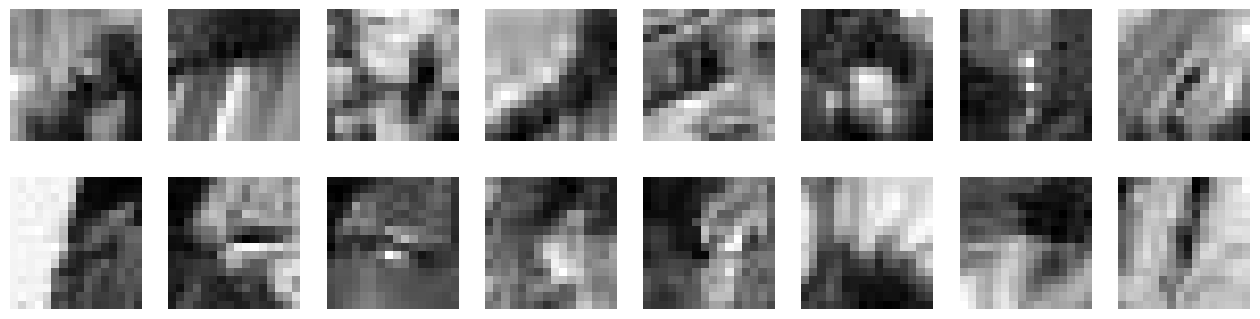

In [40]:
"""
Extract descriptors
"""
print('[ Extract descriptors ]')
desc_ex=interest_point.DescriptorExtractor()
descriptors=desc_ex.get_descriptors(img, ip)
interest_point.plot_descriptors(descriptors,plt)

我们现在将在一对图像之间匹配描述符。运行以下两个代码块来提取你的兴趣点，并提取并匹配描述符。第二个代码块调用一个函数来执行描述符的最近邻匹配，并使用比率测试进行过滤。查看代码并检查你是否理解它是如何工作的。

[ find interest points ]
 found 328 in image 1
 found 415 in image 2
  0.24 secs 
[ drawing interest points ]
  0.36 secs 


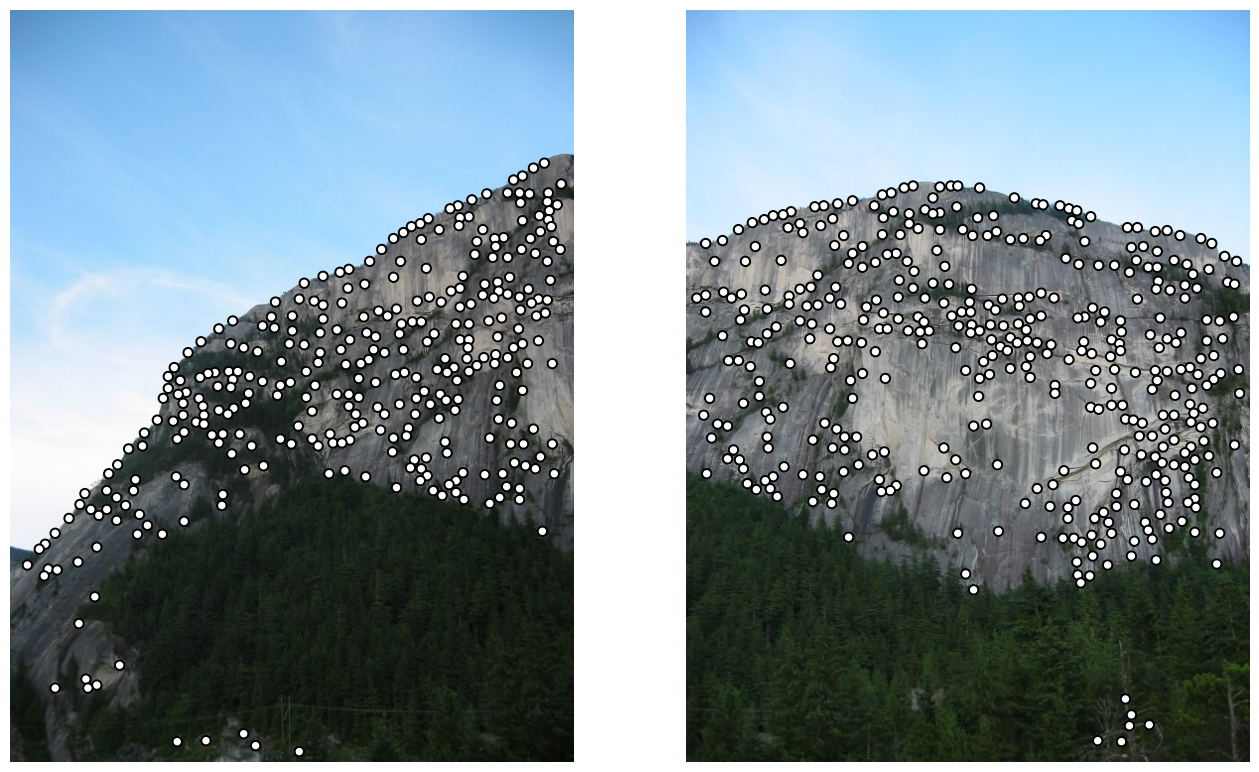

In [41]:
"""
Read a pair of input images and extract interest points
"""
image_dir='data/test'
#im_filename1=image_dir+'/100-0023_img.jpg'
#im_filename2=image_dir+'/100-0024_img.jpg'
im_filename1=image_dir+'/100-0038_img.jpg'
im_filename2=image_dir+'/100-0039_img.jpg'

im1 = im_util.image_open(im_filename1)
im2 = im_util.image_open(im_filename2)

img1 = np.mean(im1, 2, keepdims=True)
img2 = np.mean(im2, 2, keepdims=True)

print('[ find interest points ]')
t0=time()
ip_ex = interest_point.InterestPointExtractor()
ip1 = ip_ex.find_interest_points(img1)
print(' found '+str(ip1.shape[1])+' in image 1')
ip2 = ip_ex.find_interest_points(img2)
print(' found '+str(ip2.shape[1])+' in image 2')
t1=time()
print(' % .2f secs ' % (t1-t0))

print('[ drawing interest points ]')
ax1,ax2=im_util.plot_two_images(im1,im2)
t0=time()
interest_point.draw_interest_points_ax(ip1, ax1)
interest_point.draw_interest_points_ax(ip2, ax2)
t1=time()
print(' % .2f secs ' % (t1-t0))

[ extract descriptors ]
  0.11 secs
[ match descriptors ]
 Number of interest points = 328
 Number of matches passing ratio test = 82


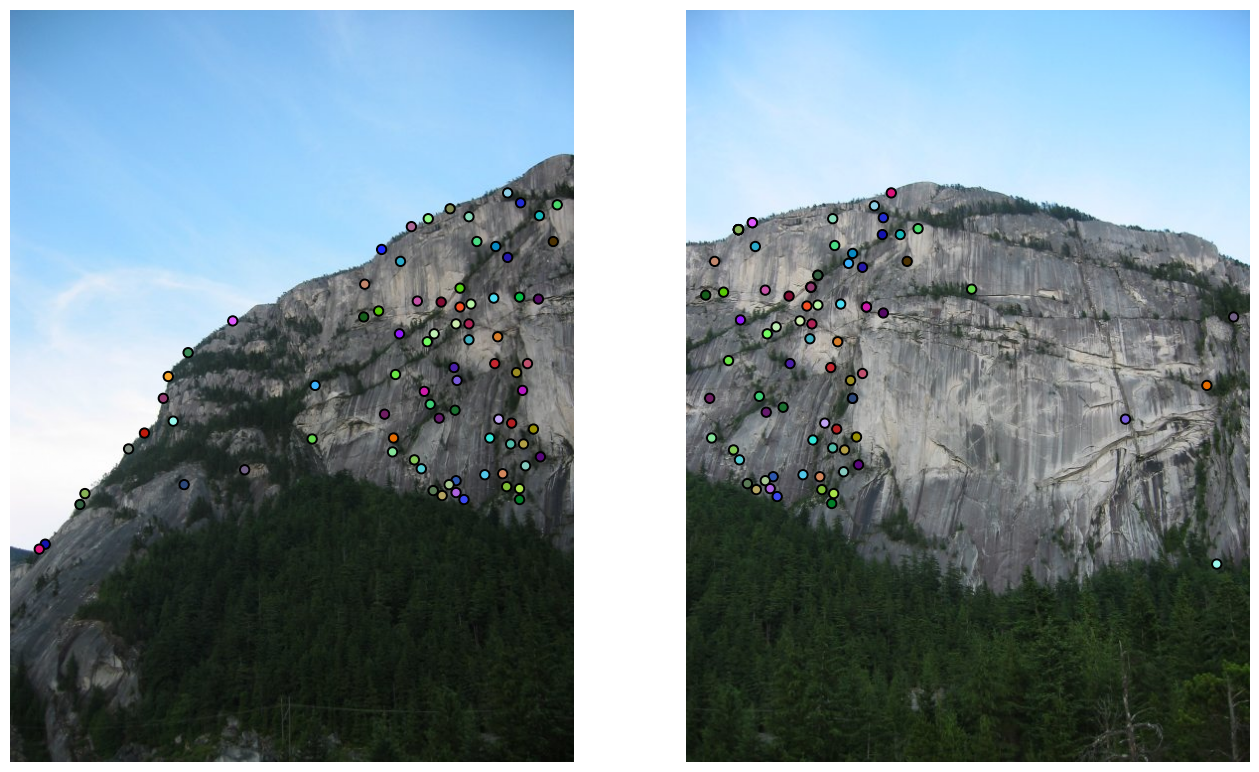

In [42]:
"""
Extract and match descriptors
"""
print('[ extract descriptors ]')
t0=time()
desc_ex = interest_point.DescriptorExtractor()
desc1 = desc_ex.get_descriptors(img1, ip1)
desc2 = desc_ex.get_descriptors(img2, ip2)
t1=time()
print(' % .2f secs' % (t1-t0))

# Uncomment the following lines to use SIFT descriptors
# Note: you'll need to install cyvlfeat, e.g., conda install -c menpo cyvlfeat

#from cyvlfeat import sift 
#frames1,desc1=sift.sift(img1,compute_descriptor=True,n_levels=1)
#frames2,desc2=sift.sift(img2,compute_descriptor=True,n_levels=1)
#ip1=(frames1.T)[0:2,:]
#ip2=(frames2.T)[0:2,:]
#desc1=desc1.astype(np.float)
#desc2=desc2.astype(np.float)

print('[ match descriptors ]')
match_idx,ratio_pass=desc_ex.match_ratio_test(desc1, desc2)
num_ratio_pass=np.sum(ratio_pass)

ipm=ip2[:,match_idx]

ip1r=ip1[:,ratio_pass]
ip2r=ipm[:,ratio_pass]

N1,num_dims=desc1.shape
print(' Number of interest points = '+str(N1))
print(' Number of matches passing ratio test = '+str(num_ratio_pass))

ax1,ax2=im_util.plot_two_images(im1,im2)
interest_point.draw_matches_ax(ip1r, ip2r, ax1, ax2)

以下代码可视化了匹配的描述符补丁。你能区分出正确和错误的匹配吗？（重新加载以获得另一个随机样本）。

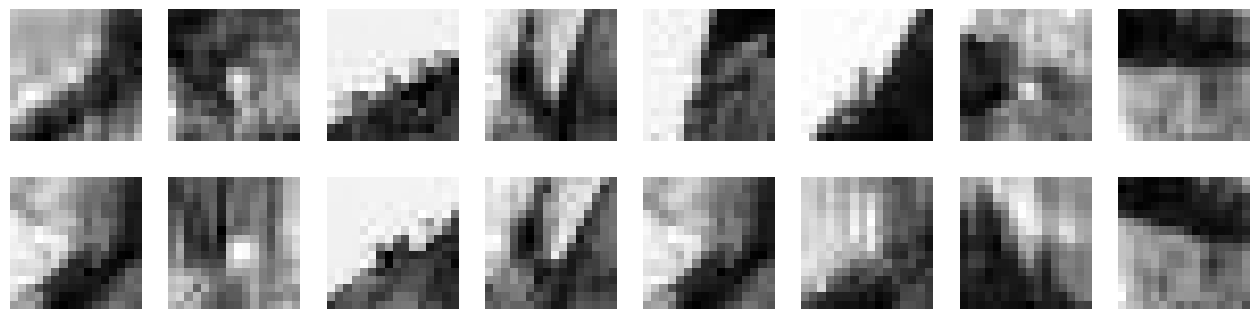

In [43]:
"""
Plot descriptors for matched points
"""
interest_point.plot_matching_descriptors(desc1,desc2,np.arange(0,ip1.shape[1]),match_idx,plt)

### 测试和改进特征匹配 [5分]

尝试改变描述符匹配器中的 `ratio_threshold` 参数（`DescriptorExtractor` 类参数）。这个参数的好设置是什么？如果一切正常，你应该会看到一组匹配正确的点（目标是大约100个或更多）。试验你的兴趣点和描述符实现，找出哪些其他参数很重要，并尝试获得一组好的匹配。尝试你自己的新想法来改进兴趣点或描述符，并在下面的笔记本中记录你的发现。确保包括足够的图表/表格和解释来展示你的基础案例和你的修改效果。

我调整 patch_size 和 ratio_threshold，通过观察图片中匹配点对的分布情况，以及可视化的 patch 图案来判断匹配的效果。我们首先固定 patch_size 的大小，然后调整 ratio，使得结果的匹配点对数量在 100 左右。
在 patch_size = 8 时，不论 ratio_threshold 设置为多少，右侧图片的右半部分都会出现被匹配到的兴趣点，而由于右侧图片仅在左侧部分与左侧图片有重叠，所以右侧图片的右半部分的匹配点对是错误的。
通过将 patch_size 增大到 16，可以看到右侧图片的右半部分的匹配点更少了，而且可视化的 patch 看起来相似度很高，这说明更大的 patch_size 有利于准确的匹配。

不论如何调整，左侧图片的左半部分，在山体与天空交接处的兴趣点都会被匹配到，这部分的错误难以消除。

在 Harris 算法中，通过增大采样的 window 大小，可以减少兴趣点的总数，但是没有显著提升匹配的质量。

或许 ratio_threshold 对应的算法并不太适合兴趣点匹配，未来或许可以考虑将兴趣点求取与 RANSAC 算法进行闭环的参数调整，以更好的匹配效果为最终目的。